Original class distribution: Counter({0: 1031335, 1: 6005})
Resampled class distribution: Counter({0: 1031335, 1: 1031335})


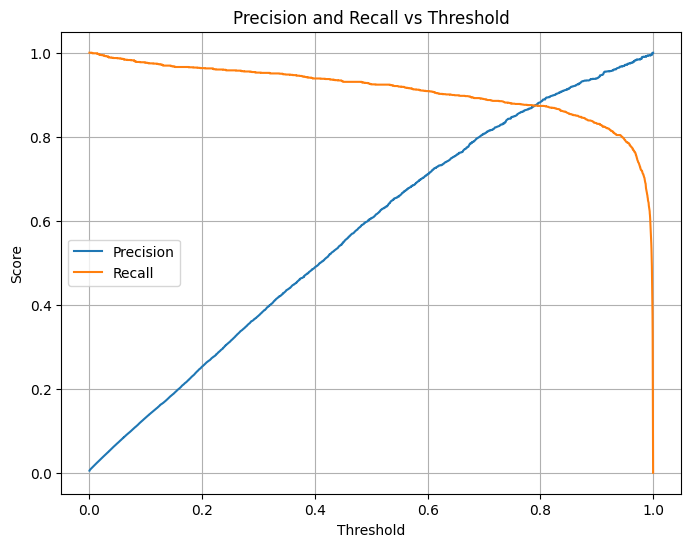

Optimal threshold selected: 0.8267996907234192
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.90      0.87      0.88      1501

    accuracy                           1.00    259335
   macro avg       0.95      0.93      0.94    259335
weighted avg       1.00      1.00      1.00    259335

Confusion Matrix:
[[257690    144]
 [   199   1302]]
ROC-AUC Score: 0.9963683929757531


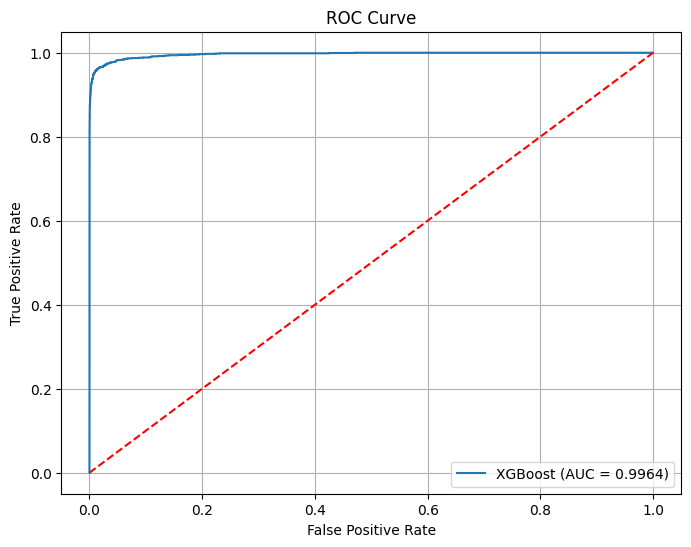

Top 20 Feature Importances:
                    Feature  Importance
1                       amt    0.246390
13     category_grocery_pos    0.116642
12   category_gas_transport    0.091310
3                      hour    0.062444
6               day_of_week    0.049859
11     category_food_dining    0.049783
18    category_shopping_net    0.038789
15            category_home    0.038190
19    category_shopping_pos    0.034748
17   category_personal_care    0.028940
16       category_kids_pets    0.028477
10   category_entertainment    0.025143
14  category_health_fitness    0.023010
2                    gender    0.019314
8         transaction_count    0.013055
4                       day    0.012123
7                       age    0.011943
5                     month    0.009532
0                    cc_num    0.008572
29                 state_TX    0.008516


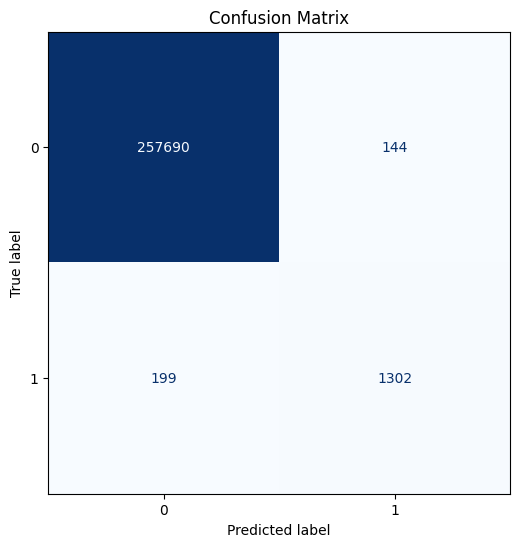

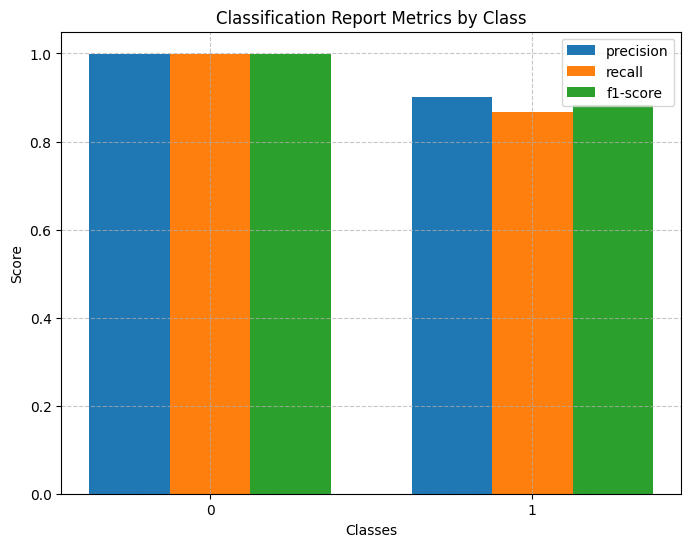

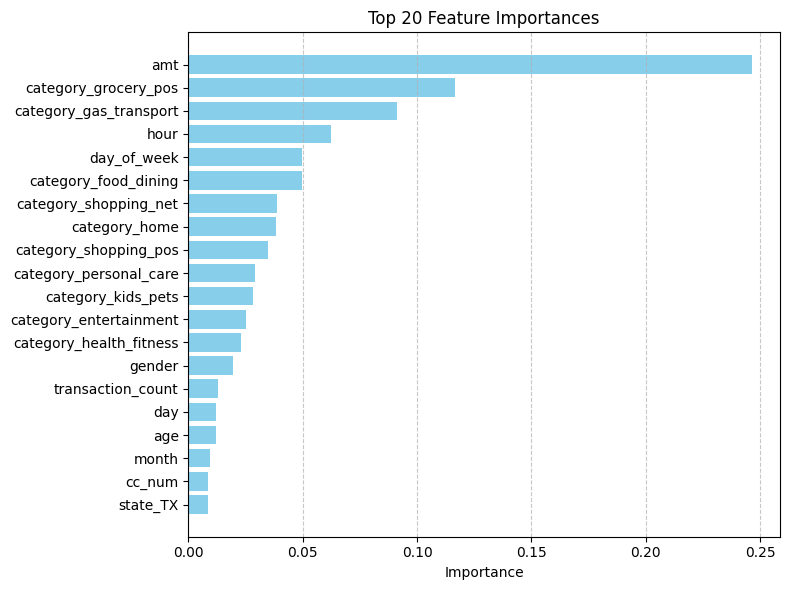

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

# Load the dataset
df = pd.read_csv('credit_card_transactions.csv')

# Remove 'Unnamed: 0'
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# ----------------------------
# Data Preprocessing and Feature Engineering
# ----------------------------

# 1. Remove unnecessary features
columns_to_drop = ['first', 'last', 'trans_num', 'unix_time', 'street', 'zip', 'merch_zipcode',
                   'merchant', 'job', 'city']
for col in columns_to_drop:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# 2. Convert 'trans_date_trans_time' to datetime and extract features
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek

# 3. Calculate age from 'dob'
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365

# 4. Drop 'dob' and 'trans_date_trans_time' as they are no longer needed
df.drop(columns=['dob', 'trans_date_trans_time'], inplace=True)

# 5. Hash 'cc_num'
df['cc_num'] = df['cc_num'].astype(str).apply(lambda x: hash(x))

# 6. Calculate transaction count per 'cc_num'
df.sort_values(['cc_num', 'day', 'hour'], inplace=True)
df['transaction_count'] = df.groupby('cc_num').cumcount() + 1

# 7. Calculate distance using Haversine formula
def haversine_vectorized(lat1, lon1, lat2, lon2):
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad)*np.cos(lat2_rad)*np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 3956  # Earth radius in miles
    return c * r

df['distance'] = haversine_vectorized(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

# Drop the original latitude and longitude columns
drop_coord_cols = ['lat', 'long', 'merch_lat', 'merch_long']
for col in drop_coord_cols:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# 8. Handle categorical variables
df['gender'] = df['gender'].map({'M': 0, 'F': 1})

top_n_categories = 10

# Category
if 'category' in df.columns:
    top_categories = df['category'].value_counts().nlargest(top_n_categories).index
    df['category'] = df['category'].where(df['category'].isin(top_categories), other='Other')
    df = pd.get_dummies(df, columns=['category'], drop_first=True)

# State
if 'state' in df.columns:
    top_states = df['state'].value_counts().nlargest(top_n_categories).index
    df['state'] = df['state'].where(df['state'].isin(top_states), other='Other')
    df = pd.get_dummies(df, columns=['state'], drop_first=True)

# 10. Handle 'city_pop'
if 'city_pop' in df.columns:
    df['city_pop_bin'] = pd.cut(df['city_pop'],
                                bins=[0, 5000, 50000, 100000, 500000, np.inf],
                                labels=['Village', 'Small', 'Medium', 'Large', 'Metropolis'])
    df = pd.get_dummies(df, columns=['city_pop_bin'], drop_first=True)
    df.drop(columns=['city_pop'], inplace=True)

# Ensure no object-type columns remain
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"Warning: Column {col} is still object-type. Consider encoding it.")
        # If any unexpected object columns appear, handle them here.

# Prepare target variable
y = df['is_fraud']
X = df.drop(columns=['is_fraud'])

# ----------------------------
# Data Splitting and Scaling
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

numerical_features = ['amt', 'age', 'distance', 'transaction_count', 'hour', 'day', 'month', 'day_of_week']
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# ----------------------------
# Handle Class Imbalance with SMOTE
# ----------------------------
print("Original class distribution:", Counter(y_train))
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
print("Resampled class distribution:", Counter(y_train_resampled))

# ----------------------------
# XGBoost Model Training
# ----------------------------
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    reg_alpha=0.1,    # Introduces L1 regularization
    reg_lambda=1.0    # L2 regularization
)

xgb_model.fit(X_train_resampled, y_train_resampled)

# ----------------------------
# Prediction and Threshold Adjustment
# ----------------------------
y_proba = xgb_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot Precision-Recall vs Threshold
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Set desired precision threshold
desired_precision = 0.9
precision_above_threshold = precision[precision >= desired_precision]
if len(precision_above_threshold) > 0:
    index = np.where(precision >= desired_precision)[0][0]
    optimal_threshold = thresholds[index]
else:
    optimal_threshold = 0.5  # Default threshold if desired precision not reached

print(f"Optimal threshold selected: {optimal_threshold}")

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

# ----------------------------
# Model Evaluation
# ----------------------------
print("Classification Report:")
print(classification_report(y_test, y_pred_adjusted))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))

print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Plot ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='XGBoost (AUC = %0.4f)' % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# ----------------------------
# Feature Importance
# ----------------------------
importances = xgb_model.feature_importances_
features = X_train.columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

print("Top 20 Feature Importances:")
print(feature_importance.head(20))

# ----------------------------
# Confusion Matrix Visualization
# ----------------------------
cm = confusion_matrix(y_test, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ----------------------------
# Classification Report Visualization
# ----------------------------
# Get the classification report as a dictionary
report_dict = classification_report(y_test, y_pred_adjusted, output_dict=True)

# The classification report dictionary has keys for each class and 'accuracy', 'macro avg', 'weighted avg'.
# We'll focus on the classes and their precision, recall, and f1-score.
classes = [str(c) for c in report_dict.keys() if c.isdigit()]
metrics = ['precision', 'recall', 'f1-score']

# Prepare data for plotting
data = {m: [report_dict[c][m] for c in classes] for m in metrics}

x = range(len(classes))
bar_width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))
for i, metric in enumerate(metrics):
    ax.bar([p + i * bar_width for p in x], data[metric], width=bar_width, label=metric)

ax.set_xlabel('Classes')
ax.set_ylabel('Score')
ax.set_title('Classification Report Metrics by Class')
ax.set_xticks([p + bar_width for p in x])
ax.set_xticklabels(classes)
ax.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# ----------------------------
# Feature Importance Visualization
# ----------------------------

top_n = 20  # number of top features to display
top_features = feature_importance.head(top_n).copy()
top_features.sort_values('Importance', ascending=True, inplace=True)  # sort by importance ascending for a nicer plot

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
ax.set_xlabel('Importance')
ax.set_title(f'Top {top_n} Feature Importances')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()